In [26]:
import numpy as np
import torch
import matplotlib.pyplot as plt


In [27]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))


In [28]:
import urllib.request
import os
from tqdm import tqdm

url = "https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth"
filename = "sam_vit_h_4b8939.pth"
folder = "models"

os.makedirs(folder, exist_ok=True)

filepath = os.path.join(folder, filename)

if not os.path.exists(filepath):
    # Get the file size before downloading
    file_size = int(urllib.request.urlopen(url).info().get("Content-Length", -1))

    # Start the download with progress bar
    with tqdm(unit="B", unit_scale=True, unit_divisor=1024, total=file_size, desc=filename, ncols=80) as pbar:
        urllib.request.urlretrieve(url, filepath, reporthook=lambda b, bsize, t: pbar.update(bsize))
else:
    print("Checkpoint file already exists. Skipping download.")

Checkpoint file already exists. Skipping download.


In [29]:
#import sys
#sys.path.append("..")
#!pip install segment_anything
from segment_anything import sam_model_registry, SamPredictor

sam_checkpoint = "models/sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

predictor = SamPredictor(sam)

In [30]:
import os
from torchvision.datasets.utils import download_url

In [31]:
# Load database with chest X-rays with lung segmentations.
data_root='./datasets'
data_npz='lung_field_dataset.npz'
data_fn = os.path.join(data_root, "lung_field_dataset.npz")
force_download = False

if (not os.path.exists(data_fn)) or force_download:
    download_url("https://sid.erda.dk/share_redirect/gCTc6o3KAh", data_root, data_npz)
else:
    print('Using existing', data_fn)

Using existing ./datasets/lung_field_dataset.npz


In [32]:
def plot_image_with_segmentation(image, segmentation, ax=None):
    """
    Plots an image with overlayed segmentation mask

    Returns: plt.fig and ax objects
    """
    if ax is None:
        fig = plt.figure(figsize=(8, 8))
        ax = fig.add_subplot(111)
        ax.axis("off")

    ax.imshow(image.squeeze(), cmap="gray")
    mask = np.ma.masked_where(segmentation == 0, segmentation)
    ax.imshow(mask.squeeze(), cmap="Set1", alpha=0.5)
    return plt.gcf(), ax


def load_npz_dataset(path, keys=('x_train', 'y_train', 'x_val', 'y_val', 'x_test', 'y_test')):
    archive = np.load(path)
    return [archive.get(key) for key in keys]

In [33]:
def map_interval(image, from_min, from_max, to_min, to_max):
    """
    Map values from [from_min, from_max] to [to_min, to_max]
    """
    from_range = from_max - from_min
    to_range = to_max - to_min
    # scaled = np.array((image - from_min) / float(from_range), dtype=float)
    scaled = (image - from_min) / float(from_range)
    return to_min + (scaled * to_range)

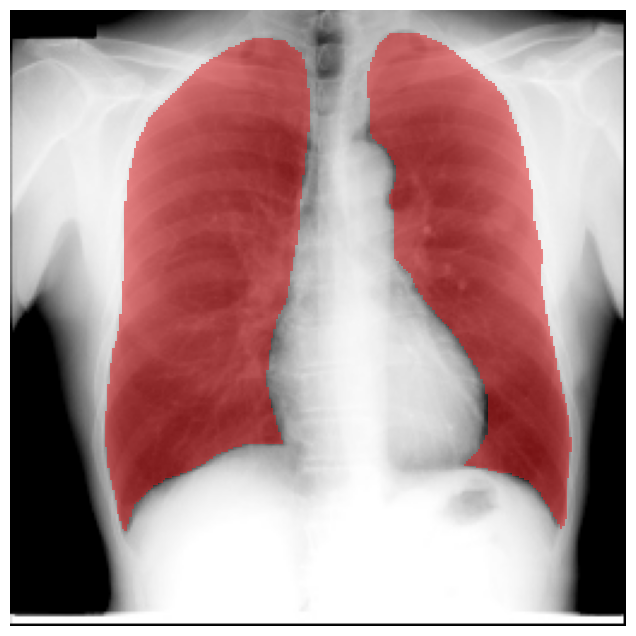

In [34]:
# Load train/val/test data
x_train, y_train, x_val, y_val, x_test, y_test = load_npz_dataset(data_fn)

# TODO:
# Bring images into the correct format for SAM:
# Image shape: (N, H, W, C=3)
# Mask shape: (N, H, W)
# Values: [0, 255] (uint8)

def convert(image):
    image = image.squeeze()
    image = np.stack([image]*3, axis=3)

    image = image + np.abs(np.min(image))
    return (image / np.max(image) * 255).astype(np.uint8)

x_train = convert(x_train)
y_train = y_train.squeeze()

x_val = convert(x_val)
y_val = y_val.squeeze()

x_test = convert(x_test)
y_test = y_test.squeeze()
# YOUR CODE HERE

# your data should pass the following asserts
assert x_train.shape == (112, 256, 256, 3)
assert y_train.shape == (112, 256, 256)
assert x_val.shape == (12, 256, 256, 3)
assert y_val.shape == (12, 256, 256)
assert x_test.shape == (123, 256, 256, 3)
assert y_test.shape == (123, 256, 256)

#assert x_train.dtype == y_train.dtype == np.uint8
assert np.min(x_train) == 0
assert np.max(x_train) == 255

# Plot an example
#print(x_train[0])
fig, ax = plot_image_with_segmentation(x_train[0], y_train[0])
plt.show()

In [35]:
def create_boxes(y):
  bounding_boxes = []

  for mask in y:

      mask_shape = mask.shape[0]
      mask_left = mask[:, 0:int(mask_shape/2)]
      mask_right = mask[:, int(mask_shape/2-1):]


      indexes_nonzero = mask_left.nonzero()

      x_left_upper1 = np.min(indexes_nonzero[1])
      y_left_upper1 = np.min(indexes_nonzero[0])

      x_right_lower1= np.max(indexes_nonzero[1])
      y_right_lower1 = np.max(indexes_nonzero[0])


      indexes_nonzero = mask_right.nonzero()

      x_left_upper2 = int(mask_shape/2) + np.min(indexes_nonzero[1])
      y_left_upper2 = np.min(indexes_nonzero[0])

      x_right_lower2= int(mask_shape/2) + np.max(indexes_nonzero[1])
      y_right_lower2 = np.max(indexes_nonzero[0])

      bounding_boxes.append([[x_left_upper1, y_left_upper1, x_right_lower1, y_right_lower1], [x_left_upper2, y_left_upper2, x_right_lower2, y_right_lower2]])


  bounding_boxes = torch.tensor(bounding_boxes, dtype=torch.float32)


  return bounding_boxes

def plot_image_with_bounding_box(image, box_l, box_r, ax=None):
    """
    Plots an image with overlayed bounding box

    Returns: plt.fig and ax objects
    """
    if ax is None:
        fig = plt.figure(figsize=(8, 8))
        ax = fig.add_subplot(111)
        ax.axis("off")

    ax.imshow(image.squeeze(), cmap="gray")
    show_box(box_l, ax)
    show_box(box_r, ax)


    return plt.gcf(), ax


bb_train = create_boxes(y_train)
bb_val = create_boxes(y_val)
bb_test = create_boxes(y_test)

In [36]:
# TODO: Implement an object detection model to find the left and right lung bounding boxes
from torch.utils.data import Dataset, DataLoader

import os
import torch

from torchvision import tv_tensors
from torchvision.transforms.v2 import functional as F

from torchvision.transforms import v2 as T


def get_transform(train):
    transforms = []
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    transforms.append(T.ToDtype(torch.float, scale=True))
    transforms.append(T.ToPureTensor())
    return T.Compose(transforms)

class LungDataset(Dataset):
    def __init__(self, images, bb, transforms):
        self.images = images
        self.transforms = transforms
        self.boxes = bb
        

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = tv_tensors.Image(self.images[idx].reshape(3, 256, 256))

        boxes = self.boxes[idx]
        
        target = {
            "boxes": tv_tensors.BoundingBoxes(boxes, format="XYXY", canvas_size=F.get_size(image)),
            "labels": torch.tensor([1, 2], dtype=torch.int64),
            "image_id": idx,
            "area": (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0]),
            "iscrowd": torch.zeros(2, dtype=torch.uint8),
        }

        if self.transforms is not None:
            image, target = self.transforms(image, target)

        return image, target
    
train_dataset = LungDataset(x_train, bb_train, get_transform(train=True))
train_dataset[0]

(tensor([[[0.0000, 0.0000, 0.0000,  ..., 0.4431, 0.4431, 0.4549],
          [0.4549, 0.4549, 0.4667,  ..., 0.6196, 0.5843, 0.5843],
          [0.5843, 0.5686, 0.5686,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.4314, 0.4314, 0.3804,  ..., 0.4353, 0.4000, 0.4000],
          [0.4000, 0.4431, 0.4431,  ..., 0.0000, 0.0000, 0.0000],
          [0.5373, 0.5373, 0.5373,  ..., 0.4588, 0.4588, 0.4902]],
 
         [[0.4902, 0.4902, 0.4235,  ..., 0.4392, 0.4588, 0.4588],
          [0.4588, 0.4824, 0.4824,  ..., 0.0000, 0.0000, 0.0000],
          [0.5059, 0.5059, 0.5059,  ..., 0.4980, 0.4980, 0.5451],
          ...,
          [0.8824, 0.8824, 0.8824,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.2314, 0.2314, 0.2549],
          [0.2549, 0.2549, 0.2431,  ..., 0.8784, 0.8784, 0.8784]],
 
         [[0.8784, 0.8706, 0.8706,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.2353, 0.2353, 0.2549],
          [0.2549, 0.2549, 0.2314,  ...,

In [37]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

def get_model_lung_detection():
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT")
    num_classes = 3
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    
    return model


In [38]:

def collate_fn(batch):
    return tuple(zip(*batch))

model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT")
dataset = LungDataset(x_train, bb_train, get_transform(train=True))
data_loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=2,
    shuffle=True,
    collate_fn=collate_fn
)

# For Training
images, targets = next(iter(data_loader))
images = list(image for image in images)
targets = [{k: v for k, v in t.items()} for t in targets]
output = model(images, targets)  # Returns losses and detections
print(output)

# For inference
model.eval()
x = [torch.rand(3, 300, 400), torch.rand(3, 500, 400)]
predictions = model(x)  # Returns predictions
print(predictions[0])

{'loss_classifier': tensor(0.7675, grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.2314, grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0894, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0110, grad_fn=<DivBackward0>)}
{'boxes': tensor([], size=(0, 4), grad_fn=<StackBackward0>), 'labels': tensor([], dtype=torch.int64), 'scores': tensor([], grad_fn=<IndexBackward0>)}


In [39]:
from engine import train_one_epoch, evaluate

# train on the GPU or on the CPU, if a GPU is not available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - background and person
num_classes = 3
# use our d
dataset = LungDataset(x_train, bb_train, get_transform(train=True))
dataset_test = LungDataset(x_val, bb_val, get_transform(train=False))

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=2,
    shuffle=True,
    collate_fn=collate_fn
)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test,
    batch_size=1,
    shuffle=False,
    collate_fn=collate_fn
)

# get the model using our helper function
model = get_model_lung_detection()

# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(
    params,
    lr=0.005,
    momentum=0.9,
    weight_decay=0.0005
)

# and a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer,
    step_size=3,
    gamma=0.1
)

# let's train it just for 2 epochs
num_epochs = 2

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

print("That's it!")

# data_test = LungDataset(x_test, bb_test, get_transform(train=False))
# data_loader_testfr = torch.utils.data.DataLoader(
#     data_test,
#     batch_size=1,
#     shuffle=False,
#     collate_fn=collate_fn
# )

# evaluate(model, data_loader_testfr, device=device)

Epoch: [0]  [ 0/56]  eta: 0:00:11  lr: 0.000096  loss: 1.7606 (1.7606)  loss_classifier: 1.4885 (1.4885)  loss_box_reg: 0.1725 (0.1725)  loss_objectness: 0.0857 (0.0857)  loss_rpn_box_reg: 0.0138 (0.0138)  time: 0.2011  data: 0.0012  max mem: 5484
Epoch: [0]  [10/56]  eta: 0:00:09  lr: 0.001004  loss: 0.6808 (1.0246)  loss_classifier: 0.4196 (0.7160)  loss_box_reg: 0.2300 (0.2320)  loss_objectness: 0.0422 (0.0611)  loss_rpn_box_reg: 0.0138 (0.0155)  time: 0.1958  data: 0.0010  max mem: 5484
Epoch: [0]  [20/56]  eta: 0:00:07  lr: 0.001912  loss: 0.5368 (0.7355)  loss_classifier: 0.2423 (0.4639)  loss_box_reg: 0.2168 (0.2187)  loss_objectness: 0.0125 (0.0377)  loss_rpn_box_reg: 0.0123 (0.0152)  time: 0.1953  data: 0.0009  max mem: 5484
Epoch: [0]  [30/56]  eta: 0:00:05  lr: 0.002820  loss: 0.3144 (0.5915)  loss_classifier: 0.1294 (0.3510)  loss_box_reg: 0.1706 (0.1975)  loss_objectness: 0.0108 (0.0291)  loss_rpn_box_reg: 0.0079 (0.0139)  time: 0.1960  data: 0.0009  max mem: 5484
Epoch: [

In [62]:
def get_predicted_boxes(model, data):   
    eval_transform = get_transform(train=False)

    model.eval()
    with torch.no_grad():
        boxes = []
        for img in data:
            img = tv_tensors.Image(img.reshape(3, 256, 256))
            x = eval_transform(img)
            x = x[:3, ...].to(device)
            predictions = model([x, ])
            pred = predictions[0]
            boxes.append(pred["boxes"][:2].cpu().numpy())
    return boxes

text_boxes = get_predicted_boxes(model, x_test)

def get_IoU(gt, predictions):
    iou = []

    for i in range(len(gt)):
        score = torchvision.ops.box_iou(torch.tensor(gt[i]), torch.tensor(predictions[i]))
        iou.append(score[0,0].item())
        iou.append(score[1,1].item())

    return np.array(iou)

iou = get_IoU(bb_test, text_boxes)

print("IoU mean:", iou.mean())
print("IoU std:", iou.std())

IoU mean: 0.6904024317164005
IoU std: 0.18707123415009316


/tmp/ipykernel_5168/3559658214.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  score = torchvision.ops.box_iou(torch.tensor(gt[i]), torch.tensor(predictions[i]))


[array([[ 32.167206,  28.282187, 120.662056, 167.6846  ],
       [146.98984 ,  24.221758, 225.3714  , 195.20494 ]], dtype=float32), array([[ 31.903568,  23.743828, 131.99556 , 218.14304 ],
       [138.04471 ,  17.088026, 222.48456 , 236.26123 ]], dtype=float32), array([[ 35.307426,  26.569443, 113.73236 , 232.03944 ],
       [140.40826 ,  18.149052, 226.8695  , 218.12437 ]], dtype=float32), array([[ 28.988647,  25.931742, 120.12787 , 170.05992 ],
       [129.76535 ,  26.698198, 226.36246 , 171.39545 ]], dtype=float32), array([[ 37.3264  ,  24.796572, 132.61455 , 203.58366 ],
       [150.64804 ,  17.440702, 228.22507 , 221.16095 ]], dtype=float32), array([[ 42.77701 ,  26.230682, 134.0395  , 186.72784 ],
       [146.73036 ,  18.285995, 226.83182 , 229.94434 ]], dtype=float32), array([[ 30.31973 ,  26.507315, 103.79406 , 214.70163 ],
       [110.085   ,  22.520565, 226.87285 , 234.09174 ]], dtype=float32), array([[ 31.29542 ,  26.432264, 112.59213 , 247.43929 ],
       [122.84996 ,  25.6

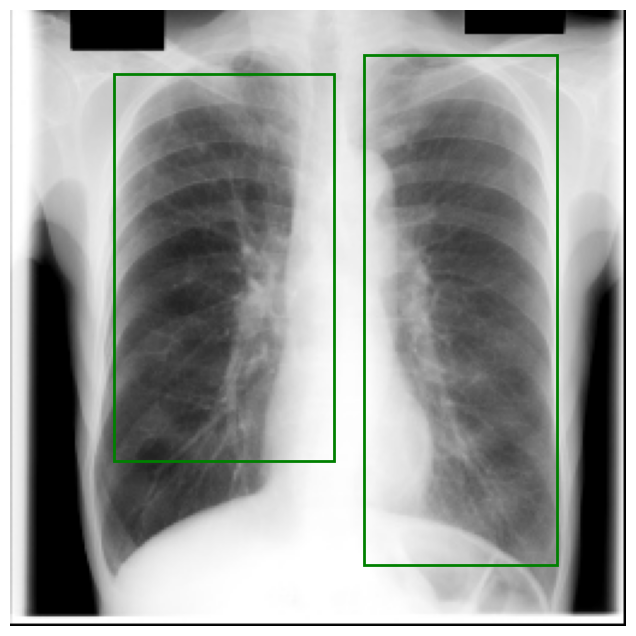

In [64]:



boxes = get_predicted_boxes(model, x_val)

plot_image_with_bounding_box(x_val[5], boxes[5][0], boxes[5][1])


#write the boxes to a file using numpy
#print(boxes)    

In [65]:
#!pip install torchmetrics
import torchmetrics

f1 = torchmetrics.F1Score(task="binary")

f1_scores = []

predictor = SamPredictor(sam)

boxes = get_predicted_boxes(model, x_test)


for img, boxs, mask_gt in zip(x_test, boxes, y_test):

    predictor.set_image(img)
    input_boxes = torch.tensor(boxs[:2])
    transformed_boxes = predictor.transform.apply_boxes_torch(input_boxes, img.shape[:2]).to(device)
    mask, scores, logits = predictor.predict_torch(
        point_coords=None,
        point_labels=None,
        boxes=transformed_boxes,
        multimask_output=False,
    )
    mask = mask[0] + mask[1]
    f1.update(torch.tensor(mask).squeeze().to("cpu"), torch.tensor(mask_gt))
    f1_scores.append(f1.compute())

mean_f1 = np.mean(f1_scores) # TODO: Compute mean F1 score
std_f1 = np.std(f1_scores) # TODO: Compute standard deviation of F1 scores

print(f"Mean F1 score: {mean_f1:.4f}")
print(f"Standard deviation: {std_f1:.4f}")

/tmp/ipykernel_5168/3711952065.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  f1.update(torch.tensor(mask).squeeze().to("cpu"), torch.tensor(mask_gt))


Mean F1 score: 0.8902
Standard deviation: 0.0043
